In [4]:
!pip install pandarallel natasha

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 102.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=bd0cad1d8ca72f3055dd3a1acde9be210acdc0a9f8298b93d0809efb47023a43
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26096 sha256=0881d007f7af495717ae8a1f4650b799978d68d0fac77f9c93d189d25cbf0d7a
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built docopt intervaltree


In [97]:
import pandas as pd
import nltk
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import toml

import random
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
import matplotlib.pyplot as plt

from utils import read_csv_data
from cleaner import clean
from dataset import AnekDataset
from model import ModelForClassification
from trainer import Trainer

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [98]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False

seed_all(42)

In [99]:
torch.cuda.is_available()

True

In [100]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [135]:
with open('bert_config.toml', 'r') as config_file:
    config = toml.load(config_file)

DATASET_PATH: str = config['dataset']['path']
TEST_SIZE: float = config['dataset']['test_size']
EVAL_SIZE: float = config['dataset']['eval_size']
MAX_LEN: int = config['dataset']['max_len']
BATCH_SIZE: int = config['dataset']['batch_size']
NUM_LABELS: int = config['dataset']['num_labels']

MODEL_NAME: str = config['model']['name']
DROPOUT_RATE: float = config['model']['dropout_rate']
N_EPOCHS: int = config['model']['n_epochs']
LR: float = config['model']['learning_rate']
WEIGHT_DECAY: float = config['model']['weight_decay']
DEVICE: str = 'cuda' if config['model']['device'] == 'gpu' else 'cpu'

In [113]:
print(N_EPOCHS)

8


In [14]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
eval = pd.read_csv('valid.csv')

In [43]:
train['text'] = train['text'].parallel_apply(clean)
test['text'] = test['text'].parallel_apply(clean)
eval['text'] = eval['text'].parallel_apply(clean)

In [44]:
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME, truncation=True, do_lower_case=True)

In [86]:
train['labels'] = train['class']
test['labels'] = test['class']
eval['labels'] = eval['class']

In [103]:
train_dataset = AnekDataset(train, tokenizer, MAX_LEN)
eval_dataset = AnekDataset(eval, tokenizer, MAX_LEN)
test_dataset = AnekDataset(test, tokenizer, MAX_LEN)

In [104]:
train_params = {"batch_size": BATCH_SIZE,
                "shuffle": True,
                "num_workers": 0
                }

test_params = {"batch_size": BATCH_SIZE,
               "shuffle": False,
               "num_workers": 0
               }

train_dataloader = DataLoader(train_dataset, **train_params)
eval_dataloader = DataLoader(eval_dataset, **test_params)
test_dataloader = DataLoader(test_dataset, **test_params)

In [136]:
config = {
    "num_classes": NUM_LABELS,
    "dropout_rate": DROPOUT_RATE
}
model = ModelForClassification(
    MODEL_NAME,
    config=config
)

In [137]:
trainer_config = {
    "lr": LR,
    "n_epochs": N_EPOCHS,
    "weight_decay": WEIGHT_DECAY,
    "batch_size": BATCH_SIZE,
    # "device": "cuda" if torch.cuda.is_available() else "cpu",
    "device": DEVICE,
    "seed": 42,
}
t = Trainer(trainer_config)

In [138]:
t.fit(
    model,
    train_dataloader,
    eval_dataloader
)

Epoch 1/8


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.6279069781303406
Epoch 2/8


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.6279069781303406
Epoch 3/8


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.6279069781303406
Epoch 4/8


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.6279069781303406
Epoch 5/8


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.6279069781303406
Epoch 6/8


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.6511628031730652
Epoch 7/8


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.6511628031730652
Epoch 8/8


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.6744186282157898


ModelForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, ele

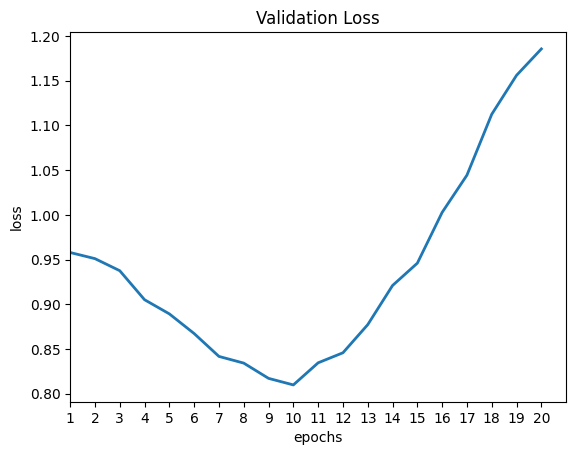

In [133]:
fig, ax = plt.subplots()

ax.plot(np.arange(1, N_EPOCHS + 1), t.history['val_loss'], linewidth=2.0)

ax.set(xlim=(1, N_EPOCHS + 1), xticks=np.arange(1, N_EPOCHS + 1), xlabel='epochs')
ax.set(ylabel='loss')
ax.set(title='Validation Loss')

plt.show()

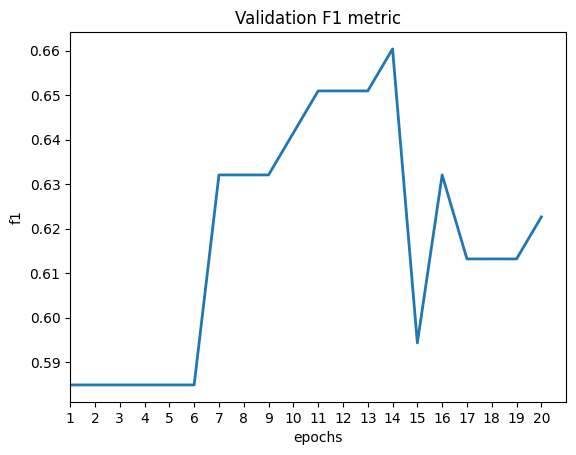

In [134]:
fig, ax = plt.subplots()

ax.plot(np.arange(1, N_EPOCHS + 1), t.history['val_acc'], linewidth=2.0)

ax.set(xlim=(1, N_EPOCHS + 1), xticks=np.arange(1, N_EPOCHS + 1), xlabel='epochs')
ax.set(ylabel='f1')
ax.set(title='Validation F1 metric')

plt.show()

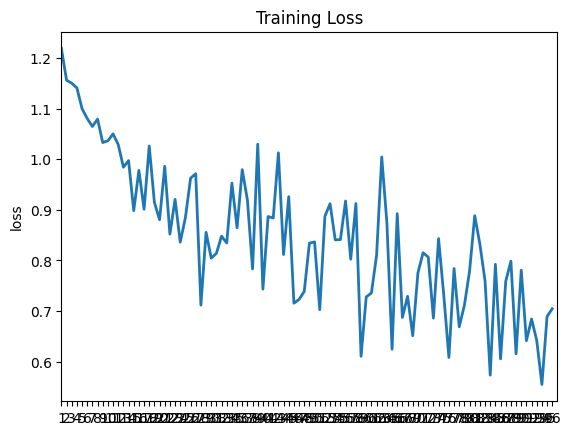

In [119]:
fig, ax = plt.subplots()

ax.plot(np.arange(1, len(t.history['train_loss']) + 1), t.history['train_loss'], linewidth=2.0)

ax.set(xlim=(1, len(t.history['train_loss']) + 1), xticks=np.arange(1, len(t.history['train_loss']) + 1))
ax.set(ylabel='loss')
ax.set(title='Training Loss')

plt.show()

In [120]:
test

,text,class,labels
0,сжатие прибор нужный выявление данный прохожде...,1,1
1,насмешка судья мухобойка верить почему покушен...,0,0
2,усложнить простой сложный женщина просто,0,0
3,брать еврей сказать отдать значить,2,2
4,аза проси верить автомобиль вождение москва бо...,0,0
...,...,...,...
101,отгул рюмочка тепло работа мимо лето 8 окно ко...,0,0
102,выпендриваться пузом походить жизнь гордиться ...,0,0
103,страна стать россия президент человек знать лю...,2,2
104,ограничение рядом надпись трейлер трэш ребенок...,0,0


In [141]:
y_pred = t.predict(test_dataloader)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [140]:
from sklearn.metrics import f1_score

In [144]:
y_true = test['labels'].tolist()

In [146]:
f1_score(y_true, y_pred, average='micro')

0.6320754716981132

In [150]:
test['text'].iloc[3]

'брать еврей сказать отдать значить'

In [153]:
t.predict(test_dataloader)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2])

In [155]:
np.array(y_true)

array([1, 0, 0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0,
       2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 1, 1, 0, 0, 0, 1, 2, 1, 0, 2, 0, 0,
       2, 2, 0, 1, 0, 1, 1, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 2, 0, 0,
       2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 2, 2, 1, 1, 0, 1, 0, 1, 1, 0, 0, 2, 0, 2])

In [156]:
test['text'].iloc[17]

'жадный забрать смотреть лондон уехать лондонский олигарх московский'

In [162]:
pd.read_csv('test.csv').iloc[-1]['text']

'Россия - уникальная страна. Ведь только у нас есть черно-белый телевизор "Радуга", наручники "Нежность", бензопила "Дружба", слезоточивый газ "Черемуха", межконтинентальные баллистические ракеты "Мир"!'

In [164]:
pd.read_csv('test.csv').iloc[-3]['text']

'В России любой человек может стать президентом. И этого человека вся страна знает.'

In [163]:
pd.read_csv('test.csv').iloc[-20]['text']

'- Вовочка, зачем ты обклеил все стены эротическими картинками?- А что, мне на голые стены смотреть?'